# scASfind: Mining Alternative Splicing Patterns in Single-cell RNA-seq Datasets

## Example analysis workflow
**Author:**  
Yuyao Song  <ys585@cam.ac.uk>


**Date:**  
May 2023 

## 1. Set up

### 1.1 Install package

In [1]:
# to install the latest release from GitHub
# install.packages("devtools")
library(devtools)
devtools::install_github("hemberg-lab/scASfind")
library(scASfind)

Loading required package: usethis

Using github PAT from envvar GITHUB_PAT

Skipping install of 'scASfind' from a github remote, the SHA1 (bd795973) has not changed since last install.
  Use `force = TRUE` to force installation



### 1.2 Load packages

In [2]:
# load the package scASfind
# also load packages for data manipulation and visulisation

library(tibble)
library(dplyr)
library(tidyr)
library(ggplot2)
library(repr)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# a useful function for setting figure size

library(repr)
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

### 1.3 Load example index

In [6]:
# These are the pre-built indices using the Tasic et al.(2016) dataset
# The dataset have detailed subtype classifications of glutamatergic neurons and GABA-ergic neurons in the mouse primary visual cortex

# index <- loadObject("../data/tasic2016_scASfind_index.rds")
load("../data/tasic2016_scASfind_index.rda")

In [9]:
data(index)

Warning message in data(index):
“data set ‘index’ not found”


In [5]:
# the index is a SCFind class object
class(index)

# the object contains four attributes
slotNames(index)

# the metadata attribute further stores splicing-related information for comprehending the results
## stats stores the mean and SD of the PSI for each node in the index
## node_list stores node related annotations
## diff_cut is a binary matrix to store if the difference of the PSI in a particular pesudobulk and the mean PSI across all pseudobulks is above the cut-off during index building (default 0.2)
## this is to distinguish between PSI = NA (the junction is unquantified), or the PSI of a node is not sufficiently different from dataset mean (PSI ~ mean_PSI) during raw PSI retrieval from index. Both circumstance is treated as 0 in the splicing matrix and compressed during index building

names(index@metadata)

[1] "SCFind"
attr(,"package")
[1] "scASfind"

[1] "index"      "datasets"   "serialized" "metadata"

[1] "stats"     "node_list" "diff_cut"

In [6]:
## the above dataset stores splicing events that has a PSI above tissue average
## the below dataset stores splicing events that has a PSI below tissue average

index@datasets

[1] "above" "below"

### 1.4 build custom index

In [7]:
## to build custom scASfind index from scratch, run the create_index.R script in scASfind/scripts
## this will create the below outputs that we load here

In [8]:
## first read in all the matrix generated from running build_matrix_original.R
load("../data/tasic_test_matrix_above.rda")
load("../data/tasic_test_stats.rda")
load("../data/tasic_test_gene_node_all.rda")
load("../data/tasic_test_diff_cut.rda")
load("../data/tasic_metadata.rda")

In [9]:
ls()

[1] "diff_cut"     "fig"          "index"        "matrix.above" "meta"        
[6] "node_list"    "stats"

In [10]:
head(meta)
dim(meta)

,pseudo_bulk_ID,samples,primary_type,cell_type,pseudo_bulk_ID_new
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Vip_Mybpc1_1,"SRR2139051,SRR2139022,SRR2138657,SRR2139077,SRR2139043",Vip_Mybpc1,Vip_Mybpc1,Vip_Mybpc1_1
2,Vip_Mybpc1_2,"SRR2139035,SRR2138604,SRR2139046,SRR2139057,SRR2140293",Vip_Mybpc1,Vip_Mybpc1,Vip_Mybpc1_2
3,Vip_Mybpc1_3,"SRR2139053,SRR2140329,SRR2140337,SRR2139042,SRR2138640",Vip_Mybpc1,Vip_Mybpc1,Vip_Mybpc1_3
4,Vip_Mybpc1_4,"SRR2138662,SRR2140291,SRR2140285,SRR2140281,SRR2138955",Vip_Mybpc1,Vip_Mybpc1,Vip_Mybpc1_4
5,Vip_Mybpc1_5,"SRR2138646,SRR2139545,SRR2139068,SRR2138643,SRR2138627",Vip_Mybpc1,Vip_Mybpc1,Vip_Mybpc1_5
6,Vip_Mybpc1_6,"SRR2138936,SRR2140292,SRR2139028,SRR2140279",Vip_Mybpc1,Vip_Mybpc1,Vip_Mybpc1_6


[1] 339   5

In [11]:
# make sure all pseudobulks are in metadata
nrow(meta[which(!(meta$pseudo_bulk_ID_new %in% colnames(matrix.above))), ]) == 0

[1] TRUE

In [12]:
levels(factor(meta$cell_type))

[1] "Astro_Gja1"    "Endo_Myl9"     "Endo_Tbc1d4"   "Igtp"         
 [5] "L2_Ngb"        "L2-3_Ptgs2"    "L4_Arf5"       "L4_Ctxn3"     
 [9] "L4_Scnn1a"     "L5_Chrna6"     "L5_Ucma"       "L5a_Batf3"    
[13] "L5a_Hsd11b1"   "L5a_Pde1c"     "L5a_Tcerg1l"   "L5b_Cdh13"    
[17] "L5b_Tph2"      "L6a_Car12"     "L6a_Mgp"       "L6a_Sla"      
[21] "L6a_Syt17"     "L6b_Rgs12"     "L6b_Serpinb11" "Micro_Ctss"   
[25] "Ndnf_Car4"     "Ndnf_Cxcl14"   "Oligo_96_Rik"  "Oligo_Opalin" 
[29] "OPC_Pdgfra"    "Pvalb_Cpne5"   "Pvalb_Gpx3"    "Pvalb_Obox3"  
[33] "Pvalb_Rspo2"   "Pvalb_Tacr3"   "Pvalb_Tpbg"    "Pvalb_Wt1"    
[37] "Smad3"         "Sncg"          "Sst_Cbln4"     "Sst_Cdk6"     
[41] "Sst_Chodl"     "Sst_Myh8"      "Sst_Tacstd2"   "Sst_Th"       
[45] "Vip_Chat"      "Vip_Gpc3"      "Vip_Mybpc1"    "Vip_Parm1"    
[49] "Vip_Sncg"

In [13]:
meta = meta[match(colnames(matrix.above), meta$pseudo_bulk_ID_new), ]

In [14]:
## make sure that the order of cell in metadata is the same with order of cell in PSI matrix
identical(meta$pseudo_bulk_ID_new, colnames(matrix.above))

[1] TRUE

In [15]:
## build the index for spliced-in events, denoted by 'above' i.e. PSI is above dataset average
idx_above <- buildAltSpliceIndex(psival = matrix.above, metadata = meta, dataset.name = 'above', column.label = 'cell_type', qb = 2)

Generating index for above

	Indexing Astro_Gja1 as above.Astro_Gja1  with  9  cells.

	Indexing Endo_Myl9 as above.Endo_Myl9  with  3  cells.

	Indexing Endo_Tbc1d4 as above.Endo_Tbc1d4  with  3  cells.

	Indexing Igtp as above.Igtp  with  3  cells.

	Indexing L2_Ngb as above.L2_Ngb  with  4  cells.

	Indexing L2-3_Ptgs2 as above.L2-3_Ptgs2  with  19  cells.

	Indexing L4_Arf5 as above.L4_Arf5  with  9  cells.

	Indexing L4_Ctxn3 as above.L4_Ctxn3  with  16  cells.

	Indexing L4_Scnn1a as above.L4_Scnn1a  with  20  cells.

	Indexing L5_Chrna6 as above.L5_Chrna6  with  3  cells.

	Indexing L5_Ucma as above.L5_Ucma  with  3  cells.

	Indexing L5a_Batf3 as above.L5a_Batf3  with  13  cells.

	Indexing L5a_Hsd11b1 as above.L5a_Hsd11b1  with  11  cells.

	Indexing L5a_Pde1c as above.L5a_Pde1c  with  4  cells.

	Indexing L5a_Tcerg1l as above.L5a_Tcerg1l  with  7  cells.

	Indexing L5b_Cdh13 as above.L5b_Cdh13  with  6  cells.

	Indexing L5b_Tph2 as above.L5b_Tph2  with  5  cells.

	Indexing 

In [16]:
idx_above <- addIndexMeta(object = idx_above, stats = stats, node_list = node_list, diff_cut = diff_cut)

## 2. Exploratory analysis

In [17]:
# first, check the encoded cell types
cell_types <- cellTypeNames(index)
cell_types

[1] "above.Astro_Gja1"    "above.Endo_Myl9"     "above.Endo_Tbc1d4"  
 [4] "above.Igtp"          "above.L2_Ngb"        "above.L4_Arf5"      
 [7] "above.L4_Ctxn3"      "above.L4_Scnn1a"     "above.L5_Chrna6"    
[10] "above.L5_Ucma"       "above.L5a_Batf3"     "above.L5a_Hsd11b1"  
[13] "above.L5a_Pde1c"     "above.L5a_Tcerg1l"   "above.L5b_Cdh13"    
[16] "above.L5b_Tph2"      "above.L6a_Car12"     "above.L6a_Mgp"      
[19] "above.L6a_Sla"       "above.L6a_Syt17"     "above.L6b_Rgs12"    
[22] "above.L6b_Serpinb11" "above.Micro_Ctss"    "above.Ndnf_Car4"    
[25] "above.Ndnf_Cxcl14"   "above.Oligo_96_Rik"  "above.Oligo_Opalin" 
[28] "above.OPC_Pdgfra"    "above.Pvalb_Cpne5"   "above.Pvalb_Gpx3"   
[31] "above.Pvalb_Obox3"   "above.Pvalb_Rspo2"   "above.Pvalb_Tacr3"  
[34] "above.Pvalb_Tpbg"    "above.Pvalb_Wt1"     "above.Smad3"        
[37] "above.Sncg"          "above.Sst_Cbln4"     "above.Sst_Cdk6"     
[40] "above.Sst_Chodl"     "above.Sst_Myh8"      "above.Sst_Tacstd2"  
[43] "above.Sst_Th"        "above.Vip_Chat"      "above.Vip_Gpc3"     
[46] "above.Vip_Mybpc1"    "above.Vip_Parm1"     "above.Vip_Sncg"     
[49] "below.Astro_Gja1"    "below.Endo_Myl9"     "below.Endo_Tbc1d4"  
[52] "below.Igtp"          "below.L2_Ngb"        "below.L4_Arf5"      
[55] "below.L4_Ctxn3"      "below.L4_Scnn1a"     "below.L5_Chrna6"    
[58] "below.L5_Ucma"       "below.L5a_Batf3"     "below.L5a_Hsd11b1"  
[61] "below.L5a_Pde1c"     "below.L5a_Tcerg1l"   "below.L5b_Cdh13"    
[64] "below.L5b_Tph2"      "below.L6a_Car12"     "below.L6a_Mgp"      
[67] "below.L6a_Sla"       "below.L6a_Syt17"     "below.L6b_Rgs12"    
[70] "below.L6b_Serpinb11" "below.Micro_Ctss"    "below.Ndnf_Car4"    
[73] "below.Ndnf_Cxcl14"   "below.Oligo_96_Rik"  "below.Oligo_Opalin" 
[76] "below.OPC_Pdgfra"    "below.Pvalb_Cpne5"   "below.Pvalb_Gpx3"   
[79] "below.Pvalb_Obox3"   "below.Pvalb_Rspo2"   "below.Pvalb_Tacr3"  
[82] "below.Pvalb_Tpbg"    "below.Pvalb_Wt1"     "below.Smad3"        
[85] "below.Sncg"          "below.Sst_Cbln4"     "below.Sst_Cdk6"     
[88] "below.Sst_Chodl"     "below.Sst_Myh8"      "below.Sst_Tacstd2"  
[91] "below.Sst_Th"        "below.Vip_Chat"      "below.Vip_Gpc3"     
[94] "below.Vip_Mybpc1"    "below.Vip_Parm1"     "below.Vip_Sncg"

In [18]:
# check the encoded genes
head(scfindNodes(object = index))

[1] "ENSMUSG00000000028.14_1"  "ENSMUSG00000000028.14_2" 
[3] "ENSMUSG00000000028.14_24" "ENSMUSG00000000028.14_25"
[5] "ENSMUSG00000000028.14_8"  "ENSMUSG00000000037.16_36"

### 2.1 Search marker nodes of an interested cell type

In [19]:
interested_cell_type <- "above.Astro_Gja1"

# rank the splicing nodes by their frequency of inclusion that is above dataset mean in the interested cell type

markers <- cellTypeMarkers(index, interested_cell_type, background.cell.types = cellTypeNames(index, datasets = 'above'), top.k = 20)
markers

nodes,cellType,tp,fp,fn,precision,recall,f1,Gene_num,Gene_id,Node,Coord,Strand,Type,Gene_name,Node_name
<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
ENSMUSG00000004980.16_32,above.Astro_Gja1,8,5,1,0.6153846,0.8888889,0.7272727,ENSMUSG00000004980,ENSMUSG00000004980.16,32,chr6:51463255-51463410,-,RI,Hnrnpa2b1,Hnrnpa2b1_32
ENSMUSG00000017390.15_4,above.Astro_Gja1,8,4,1,0.6666667,0.8888889,0.7619048,ENSMUSG00000017390,ENSMUSG00000017390.15,4,chr11:78324200-78324325,+,TS,Aldoc,Aldoc_4
ENSMUSG00000019437.17_22,above.Astro_Gja1,6,3,3,0.6666667,0.6666667,0.6666667,ENSMUSG00000019437,ENSMUSG00000019437.17,22,chr11:78180175-78180480,+,TE,Tlcd1,Tlcd1_22
ENSMUSG00000024292.14_8,above.Astro_Gja1,5,1,4,0.8333333,0.5555556,0.6666667,ENSMUSG00000024292,ENSMUSG00000024292.14,8,chr17:32909122-32909392,-,CE,Cyp4f14,Cyp4f14_8
ENSMUSG00000027737.10_20,above.Astro_Gja1,9,4,0,0.6923077,1.0000000,0.8181818,ENSMUSG00000027737,ENSMUSG00000027737.10,20,chr3:50364938-50369848,-,TE,Slc7a11,Slc7a11_20
ENSMUSG00000029570.5_12,above.Astro_Gja1,5,0,4,1.0000000,0.5555556,0.7142857,ENSMUSG00000029570,ENSMUSG00000029570.5,12,chr5:140614675-140615545,+,TE,Lfng,Lfng_12
ENSMUSG00000030088.15_6,above.Astro_Gja1,6,3,3,0.6666667,0.6666667,0.6666667,ENSMUSG00000030088,ENSMUSG00000030088.15,6,chr6:90550898-90550970,+,AD,Aldh1l1,Aldh1l1_6
ENSMUSG00000030235.17_2,above.Astro_Gja1,9,4,0,0.6923077,1.0000000,0.8181818,ENSMUSG00000030235,ENSMUSG00000030235.17,2,chr6:141524386-141524398,+,TS,Slco1c1,Slco1c1_2
ENSMUSG00000030495.12_17,above.Astro_Gja1,9,6,0,0.6000000,1.0000000,0.7500001,ENSMUSG00000030495,ENSMUSG00000030495.12,17,chr7:35200896-35200914,+,TE,Slc7a10,Slc7a10_17


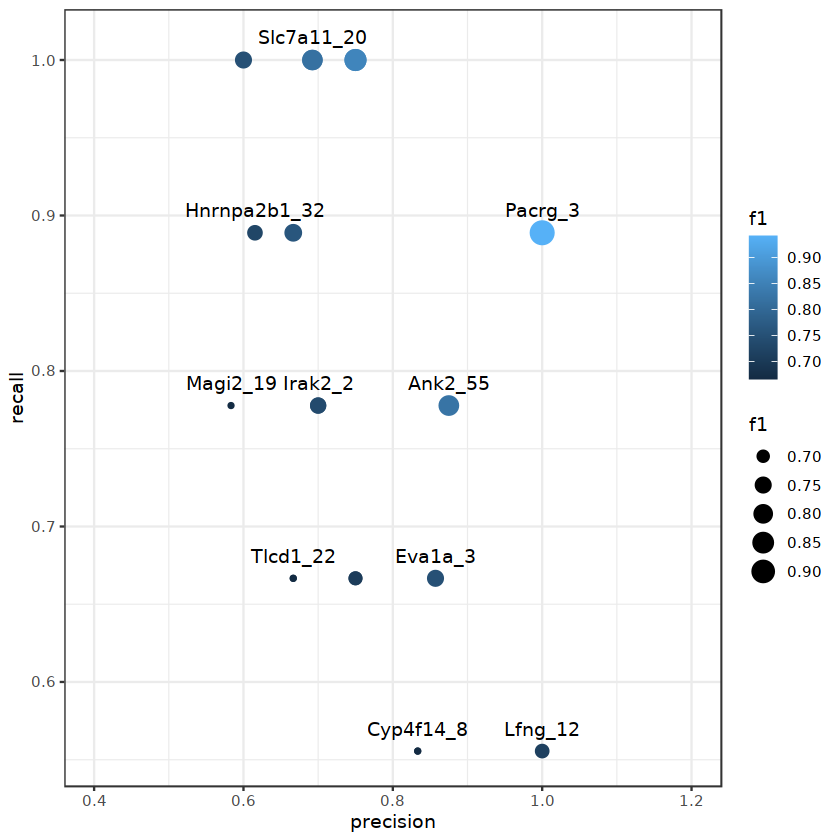

In [20]:
# plot the nodes using their precision. recall and f1 scores to examine

ggplot(markers, aes(x = precision, y = recall, colour = f1, label = Node_name)) +
theme_bw() + 
geom_point(aes(size = f1)) +
geom_text(vjust = 0, 
          nudge_y = 0.01, 
          colour = "black", 
          check_overlap = T) +
xlim(0.4, 1.2)

fig(6, 6)

In [21]:
## get the annotations of query nodes
## use the markers of interested cell type as example
nodeDetails(index, as.character(markers$nodes))

,Gene_num,Gene_id,Node,Coord,Strand,Type,Node_id,Gene_name,Node_name
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4612,ENSMUSG00000004980,ENSMUSG00000004980.16,32,chr6:51463255-51463410,-,RI,ENSMUSG00000004980.16_32,Hnrnpa2b1,Hnrnpa2b1_32
10208,ENSMUSG00000017390,ENSMUSG00000017390.15,4,chr11:78324200-78324325,+,TS,ENSMUSG00000017390.15_4,Aldoc,Aldoc_4
11779,ENSMUSG00000019437,ENSMUSG00000019437.17,22,chr11:78180175-78180480,+,TE,ENSMUSG00000019437.17_22,Tlcd1,Tlcd1_22
25419,ENSMUSG00000024292,ENSMUSG00000024292.14,8,chr17:32909122-32909392,-,CE,ENSMUSG00000024292.14_8,Cyp4f14,Cyp4f14_8
36073,ENSMUSG00000027737,ENSMUSG00000027737.10,20,chr3:50364938-50369848,-,TE,ENSMUSG00000027737.10_20,Slc7a11,Slc7a11_20
42891,ENSMUSG00000029570,ENSMUSG00000029570.5,12,chr5:140614675-140615545,+,TE,ENSMUSG00000029570.5_12,Lfng,Lfng_12
44346,ENSMUSG00000030088,ENSMUSG00000030088.15,6,chr6:90550898-90550970,+,AD,ENSMUSG00000030088.15_6,Aldh1l1,Aldh1l1_6
44763,ENSMUSG00000030235,ENSMUSG00000030235.17,2,chr6:141524386-141524398,+,TS,ENSMUSG00000030235.17_2,Slco1c1,Slco1c1_2
45504,ENSMUSG00000030495,ENSMUSG00000030495.12,17,chr7:35200896-35200914,+,TE,ENSMUSG00000030495.12_17,Slc7a10,Slc7a10_17


### 2.2 Search cell types enriched in an interested splicing event

In [22]:
# find all nodes in a particular gene

Gria2_nodes <- geneNodes(index, "Gria2", "Gene_name")
Gria2_nodes <- Gria2_nodes[order(as.numeric(as.character(Gria2_nodes$Node))), ]
Gria2_nodes

,Gene_num,Gene_id,Node,Coord,Strand,Type,Node_id,Gene_name,Node_name
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
55244,ENSMUSG00000033981,ENSMUSG00000033981.14,3,chr3:80802725-80802780,-,TS,ENSMUSG00000033981.14_3,Gria2,Gria2_3
55240,ENSMUSG00000033981,ENSMUSG00000033981.14,4,chr3:80802694-80802724,-,TS,ENSMUSG00000033981.14_4,Gria2,Gria2_4
55243,ENSMUSG00000033981,ENSMUSG00000033981.14,5,chr3:80802651-80802693,-,TS,ENSMUSG00000033981.14_5,Gria2,Gria2_5
55237,ENSMUSG00000033981,ENSMUSG00000033981.14,6,chr3:80802580-80802650,-,TS,ENSMUSG00000033981.14_6,Gria2,Gria2_6
55249,ENSMUSG00000033981,ENSMUSG00000033981.14,7,chr3:80802297-80802579,-,TS,ENSMUSG00000033981.14_7,Gria2,Gria2_7
55245,ENSMUSG00000033981,ENSMUSG00000033981.14,21,chr3:80706353-80706887,-,TE,ENSMUSG00000033981.14_21,Gria2,Gria2_21
55247,ENSMUSG00000033981,ENSMUSG00000033981.14,22,chr3:80704639-80706352,-,TE,ENSMUSG00000033981.14_22,Gria2,Gria2_22
55242,ENSMUSG00000033981,ENSMUSG00000033981.14,25,chr3:80691744-80692284,-,RI,ENSMUSG00000033981.14_25,Gria2,Gria2_25
55246,ENSMUSG00000033981,ENSMUSG00000033981.14,26,chr3:80691703-80691743,-,CE,ENSMUSG00000033981.14_26,Gria2,Gria2_26


In [23]:
# query significant cell types by a specific splicing event
## accept logical operators: prepend "-" means node exclusion

Gria2_mxe <- c("ENSMUSG00000033981.14_28", "ENSMUSG00000033981.14_29")
hyperQueryCellTypes(index, c("ENSMUSG00000033981.14_28", "-ENSMUSG00000033981.14_29"), datasets = 'above') %>% arrange(pval)

Found 124 cell expressing ENSMUSG00000033981.14_28

Excluded 4 cells expressing ENSMUSG00000033981.14_29



cell_type,cell_hits,total_cells,pval
<chr>,<int>,<dbl>,<dbl>
above.Igtp,3,3,0.0000000
above.Pvalb_Obox3,4,4,0.0000000
above.Pvalb_Wt1,11,11,0.0000000
above.Smad3,3,3,0.0000000
above.Vip_Sncg,3,3,0.0000000
above.L4_Arf5,8,9,0.2240541
above.Sst_Myh8,7,8,0.3986078
above.Ndnf_Cxcl14,6,7,0.7059205
above.Astro_Gja1,1,9,1.0000000


### 3. Retrieve actual PSI for discovered splicing patterns

In [24]:
## check the raw PSI value of query nodes in particular cell types, return a dataframe with cell type, node raw PSI and node details

raw_psi = getRawPsi(object = index, node.list = Gria2_mxe, cell.types = gsub("above\\.", "", cellTypeNames(index, datasets = 'above')), verbose = FALSE)
head(raw_psi)

,Node_id,Cell_id,raw_psi,Gene_num,Gene_id,Node,Coord,Strand,Type,Gene_name,Node_name
,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000033981.14_28,Astro_Gja1_1,1,ENSMUSG00000033981,ENSMUSG00000033981.14,28,chr3:80691320-80691434,-,CE,Gria2,Gria2_28
2,ENSMUSG00000033981.14_28,Astro_Gja1_2,NA,ENSMUSG00000033981,ENSMUSG00000033981.14,28,chr3:80691320-80691434,-,CE,Gria2,Gria2_28
3,ENSMUSG00000033981.14_28,Astro_Gja1_3,1,ENSMUSG00000033981,ENSMUSG00000033981.14,28,chr3:80691320-80691434,-,CE,Gria2,Gria2_28
4,ENSMUSG00000033981.14_28,Astro_Gja1_4,1,ENSMUSG00000033981,ENSMUSG00000033981.14,28,chr3:80691320-80691434,-,CE,Gria2,Gria2_28
5,ENSMUSG00000033981.14_28,Astro_Gja1_5,NA,ENSMUSG00000033981,ENSMUSG00000033981.14,28,chr3:80691320-80691434,-,CE,Gria2,Gria2_28
6,ENSMUSG00000033981.14_28,Astro_Gja1_6,NA,ENSMUSG00000033981,ENSMUSG00000033981.14,28,chr3:80691320-80691434,-,CE,Gria2,Gria2_28


### 4. Heatmap of PSI value of a splicing pattern

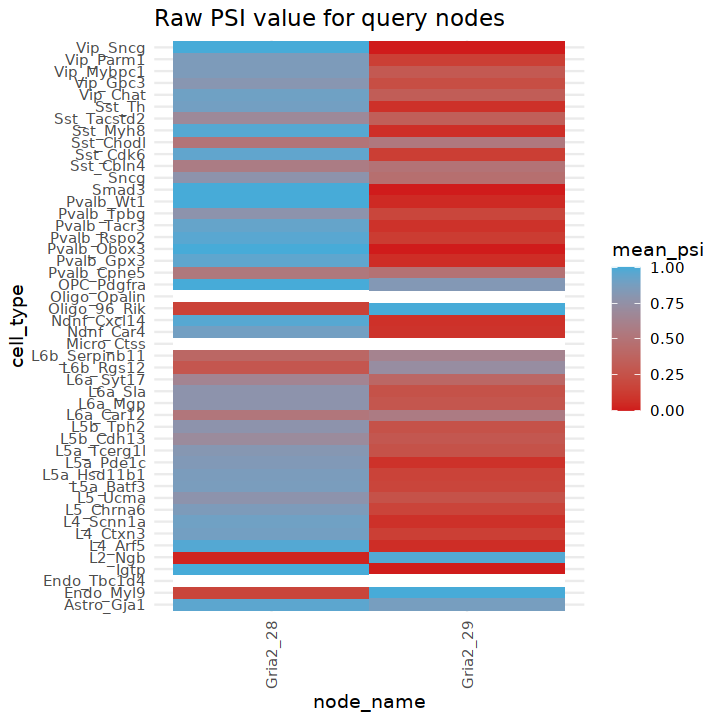

In [25]:
## generate a heatmap for raw PSI values

plotRawPsiHeatmap(raw_psi = raw_psi, node.list = Gria2_mxe, cell.types = gsub("above\\.", "", cellTypeNames(index, datasets = 'above')))

fig(6, 10)

In [26]:
## find nodes with a similar splcing pattern with query nodes
## takes some minuites

findSimilarNodes(object = index, node.list = Gria2_mxe[1], datasets = 'above', top.k = 10)

Searching for genes with similar pattern...



  |======================================================================| 100%


gene,Jaccard,overlap,n
<chr>,<dbl>,<dbl>,<dbl>
ENSMUSG00000092083.4_5,0.3676471,75,155
ENSMUSG00000009681.10_31,0.3720930,80,171
ENSMUSG00000061751.15_100,0.3743017,67,122
ENSMUSG00000050587.14_2,0.3750000,75,151
ENSMUSG00000032479.15_18,0.3761468,82,176
ENSMUSG00000026554.15_38,0.3796296,82,174
ENSMUSG00000002280.10_25,0.3820755,81,169
ENSMUSG00000066392.11_38,0.3830846,77,154
ENSMUSG00000001986.16_28,0.3866667,58,84


In [27]:
above_glul5 = cell_types[grep("above\\.L5", cell_types)]

In [28]:
above_glul5

[1] "above.L5_Chrna6"   "above.L5_Ucma"     "above.L5a_Batf3"  
[4] "above.L5a_Hsd11b1" "above.L5a_Pde1c"   "above.L5a_Tcerg1l"
[7] "above.L5b_Cdh13"   "above.L5b_Tph2"

In [29]:
# find house keeping nodes in a particular group of cell types
## use L5 glutamatergic neurons as example

above_glul5_nodes = findHouseKeepingNodes(object = index, cell.types = above_glul5)
above_glul5_nodes

Searching for house keeping node...



  |======================================================================| 100%


[1] "ENSMUSG00000001211.15_34" "ENSMUSG00000002825.7_7"  
[3] "ENSMUSG00000007739.10_4"  "ENSMUSG00000015522.18_44"
[5] "ENSMUSG00000020111.15_21" "ENSMUSG00000020156.16_41"

In [30]:
nodeDetails(object = index, node.list = above_glul5_nodes)

,Gene_num,Gene_id,Node,Coord,Strand,Type,Node_id,Gene_name,Node_name
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1131,ENSMUSG00000001211,ENSMUSG00000001211.15,34,chr10:78269178-78271562,-,TE,ENSMUSG00000001211.15_34,Agpat3,Agpat3_34
2699,ENSMUSG00000002825,ENSMUSG00000002825.7,7,chr9:21411871-21411876,+,TS,ENSMUSG00000002825.7_7,Qtrt1,Qtrt1_7
6576,ENSMUSG00000007739,ENSMUSG00000007739.10,4,chr11:22990650-22990651,+,TS,ENSMUSG00000007739.10_4,Cct4,Cct4_4
9276,ENSMUSG00000015522,ENSMUSG00000015522.18,44,chr3:95495572-95497237,+,TE,ENSMUSG00000015522.18_44,Arnt,Arnt_44
13315,ENSMUSG00000020111,ENSMUSG00000020111.15,21,chr10:59767084-59767089,+,CE,ENSMUSG00000020111.15_21,Micu1,Micu1_21
13476,ENSMUSG00000020156,ENSMUSG00000020156.16,41,chr10:80243902-80243903,+,TE,ENSMUSG00000020156.16_41,Pwwp3a,Pwwp3a_41


In [31]:
## find signature splicing events for particular cell types

findNodeSignatures(object = index, cell.types = above_glul5)

Searching for node signatures...



  |======================================================================| 100%


list()

In [32]:
## find all cells per cell type that express the full set of nodes in gene.list

findCellTypes(object = index, gene.list = Gria2_mxe[1], datasets = 'above')

$above.Pvalb_Gpx3
 [1]  1  2  3  5  6  7  8  9 10 12

$above.OPC_Pdgfra
[1] 4

$above.Ndnf_Cxcl14
[1] 1 2 3 4 5 6

$above.L4_Arf5
[1] 1 2 3 4 5 6 7 8

$above.L5a_Tcerg1l
[1] 1

$above.Ndnf_Car4
[1] 1 2 6

$above.L4_Scnn1a
 [1]  1  2  3  4  5  7  8 11 15 16 18

$above.Pvalb_Tacr3
[1]  1  2  4  5  7  9 10 12 13

$above.L5a_Batf3
[1]  3  5  7 10 12

$above.L5_Chrna6
[1] 2

$above.Vip_Parm1
[1] 1 3 5

$above.Astro_Gja1
[1] 1 3 4 8

$above.L4_Ctxn3
[1]  3  4  7  8 11 13 15 16

$above.L5a_Hsd11b1
[1]  3  4  6 10

$above.L5a_Pde1c
[1] 2

$above.Igtp
[1] 1 2 3

$above.Pvalb_Obox3
[1] 1 2 3 4

$above.Smad3
[1] 1 2 3

$above.Sst_Th
[1] 1 2

$above.Pvalb_Wt1
 [1]  1  2  3  4  5  6  7  8  9 10 11

$above.Sst_Myh8
[1] 1 2 3 4 5 6 8

$above.Sst_Cdk6
[1] 2 3 4

$above.Vip_Chat
[1]  4  5  6  9 10

$above.Vip_Gpc3
[1] 4

$above.Vip_Sncg
[1] 1 2 3

$above.Vip_Mybpc1
[1] 1 5

$above.Pvalb_Rspo2
[1] 1 2 4 5 6


## long query optimization routine

In [33]:
Gria2_nodes$Node_id

[1] "ENSMUSG00000033981.14_3"  "ENSMUSG00000033981.14_4" 
 [3] "ENSMUSG00000033981.14_5"  "ENSMUSG00000033981.14_6" 
 [5] "ENSMUSG00000033981.14_7"  "ENSMUSG00000033981.14_21"
 [7] "ENSMUSG00000033981.14_22" "ENSMUSG00000033981.14_25"
 [9] "ENSMUSG00000033981.14_26" "ENSMUSG00000033981.14_28"
[11] "ENSMUSG00000033981.14_29" "ENSMUSG00000033981.14_30"
[13] "ENSMUSG00000033981.14_31" "ENSMUSG00000033981.14_32"
[15] "ENSMUSG00000033981.14_33"

In [34]:
markerNodes(object = idx_above, gene.list = Gria2_nodes$Node_id, log.message = TRUE)

Ignored ENSMUSG00000033981.14_30. Not found in the index



calculating tfidf for the reduced expression matrix... 
gene ENSMUSG00000033981.14_3 cell type above.Oligo_96_Rik 181717
gene ENSMUSG00000033981.14_4 cell type above.Sncg 217858
gene ENSMUSG00000033981.14_4 cell type above.Pvalb_Gpx3 221764
gene ENSMUSG00000033981.14_4 cell type above.Pvalb_Gpx3 222622
gene ENSMUSG00000033981.14_4 cell type above.Pvalb_Gpx3 237136
gene ENSMUSG00000033981.14_4 cell type above.Pvalb_Cpne5 178459
gene ENSMUSG00000033981.14_4 cell type above.OPC_Pdgfra 201189
gene ENSMUSG00000033981.14_4 cell type above.Oligo_96_Rik 181717
gene ENSMUSG00000033981.14_4 cell type above.Ndnf_Cxcl14 208537
gene ENSMUSG00000033981.14_4 cell type above.L6a_Syt17 230532
gene ENSMUSG00000033981.14_4 cell type above.L6a_Sla 229942
gene ENSMUSG00000033981.14_4 cell type above.L6a_Sla 232456
gene ENSMUSG00000033981.14_4 cell type above.L6a_Sla 234547
gene ENSMUSG00000033981.14_4 cell type above.L6a_Sla 229492
gene ENSMUSG00000033981.14_4 cell type above.Igtp 179237
gene ENSMUSG000000

Genes,Query,tfidf,Cells
<int>,<chr>,<dbl>,<int>
2,"ENSMUSG00000033981.14_21,ENSMUSG00000033981.14_25",0.005816618,22
3,"ENSMUSG00000033981.14_21,ENSMUSG00000033981.14_25,ENSMUSG00000033981.14_26",0.008459462,21
4,"ENSMUSG00000033981.14_21,ENSMUSG00000033981.14_25,ENSMUSG00000033981.14_26,ENSMUSG00000033981.14_28",0.007147757,15
3,"ENSMUSG00000033981.14_21,ENSMUSG00000033981.14_25,ENSMUSG00000033981.14_28",0.005300863,16
2,"ENSMUSG00000033981.14_21,ENSMUSG00000033981.14_26",0.006190429,22
3,"ENSMUSG00000033981.14_21,ENSMUSG00000033981.14_26,ENSMUSG00000033981.14_28",0.005379020,16
3,"ENSMUSG00000033981.14_21,ENSMUSG00000033981.14_26,ENSMUSG00000033981.14_6",0.005969261,4
2,"ENSMUSG00000033981.14_21,ENSMUSG00000033981.14_28",0.003532126,40
3,"ENSMUSG00000033981.14_21,ENSMUSG00000033981.14_28,ENSMUSG00000033981.14_4",0.005046127,4


In [35]:
getCoordinatedNodes(object = idx_above, gene.name = 'Gria2')


calculating tfidf for the reduced expression matrix... 


Genes,Query,tfidf,Cells
<int>,<chr>,<dbl>,<int>
4,"ENSMUSG00000033981.14_22,ENSMUSG00000033981.14_25,ENSMUSG00000033981.14_26,ENSMUSG00000033981.14_7",0.04110427,6
4,"ENSMUSG00000033981.14_21,ENSMUSG00000033981.14_29,ENSMUSG00000033981.14_31,ENSMUSG00000033981.14_4",0.03650237,6
4,"ENSMUSG00000033981.14_25,ENSMUSG00000033981.14_26,ENSMUSG00000033981.14_29,ENSMUSG00000033981.14_4",0.03353593,6
3,"ENSMUSG00000033981.14_25,ENSMUSG00000033981.14_26,ENSMUSG00000033981.14_33",0.03388437,6
3,"ENSMUSG00000033981.14_25,ENSMUSG00000033981.14_26,ENSMUSG00000033981.14_32",0.03332801,6
3,"ENSMUSG00000033981.14_22,ENSMUSG00000033981.14_25,ENSMUSG00000033981.14_7",0.03107206,6


In [36]:
findNodeSets(object = idx_above, gene.list = c("Golgb1"), query.type = 'Gene_name', node.types = c("CE", "AA", 'AD', 'RI', NA))


Ignored ENSMUSG00000034243.16_12, ENSMUSG00000034243.16_20, ENSMUSG00000034243.16_23. Not found in the index



calculating tfidf for the reduced expression matrix... 


running hyperQueryCellType using



[1] "ENSMUSG00000034243.16_7" "ENSMUSG00000034243.16_8"
[3] "ENSMUSG00000034243.16_9"
            cell_type cell_hits total_cells      pval
1    above.Astro_Gja1         2           9 1.0000000
2     above.Endo_Myl9         2           3 0.3315749
3   above.Endo_Tbc1d4         2           3 0.3315749
4          above.Igtp         1           3 1.0000000
5    above.L2-3_Ptgs2         2          19 1.0000000
6       above.L4_Arf5         1           9 1.0000000
7      above.L4_Ctxn3         5          16 1.0000000
8     above.L4_Scnn1a         3          20 1.0000000
9     above.L5_Chrna6         2           3 0.3315749
10    above.L5a_Batf3         1          13 1.0000000
11  above.L5a_Hsd11b1         2          11 1.0000000
12  above.L5a_Tcerg1l         1           7 1.0000000
13    above.L5b_Cdh13         1           6 1.0000000
14      above.L6a_Mgp         1           8 1.0000000
15   above.Micro_Ctss         4           4 0.0000000
16 above.Oligo_96_Rik         1           3 1.0000

find a cell type specific node set 




[1] "ENSMUSG00000034243.16_7" "ENSMUSG00000034243.16_8"
[3] "ENSMUSG00000034243.16_9"


,cell_type,cell_hits,total_cells,pval
,<chr>,<int>,<dbl>,<dbl>
15,above.Micro_Ctss,4,4,0


In [37]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.5 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /nfs/research/icortes/ysong/anaconda3/envs/maftools/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] repr_1.1.3     ggplot2_3.3.6  tidyr_1.2.0    dplyr_1.0.8    tibble_3.1.7  
[6] scASfind_0.1.0 devtools_2.4.3 usethis_2.0.1 

loaded via a namespace (and not attached):
  [1] fs_1.5.2             lubridate_1.8.0      bit64_4.0.5         
  [4] RColorBrewer_1.1-3   rprojr

In [38]:
rm()